In [192]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy.integrate import odeint, ode
import inspect
import collections
from uncertainties import ufloat
from scipy.signal import argrelextrema

plt.rcParams["figure.dpi"] = 150

In [193]:
class DataRun:

    def __init__(
        self,
        csv: str,
        start_frame,
        end_frame,
        px1: tuple,
        px2: tuple,
        gas: str,
        water_height=0,
        pr=ufloat(101557.8, 169.319),
        p0=(0.05, 14, -2, 0, 50, 0),
        col=1,
        FPS=60,
    ):
        ppcm = (px2[0] - px1[0]) / (px2[1] - px1[1])  # pixels per cm
        b = px1[0] - ppcm * px1[1]
        xint = -b / ppcm
        print(f"Pixels per Cm: {ppcm}")
        # print(f"Cm at px=0: {xint : 0.3g}")
        df2 = pd.read_csv(csv)
        # print(df2)
        y = np.array(df2.iloc[:, col].dropna()) / ppcm + xint
        # print(y)
        t = np.linspace(0, len(y) / FPS, len(y))

        start_frame = int(start_frame)
        end_frame = int(end_frame)
        self.t = t[(start_frame):(end_frame)]
        self.y = y[(start_frame):(end_frame)]
        self.gas = gas
        self.water_height = water_height
        self.start_frame = start_frame
        self.end_frame = end_frame
        self.csv = csv
        self.pr = pr
        self.initParams()
        self.p0 = p0
        plt.scatter(self.t, self.y)
        plt.title(f"{csv}: {gas} from {start_frame}-{end_frame}")
        plt.show()
        plt.clf()

    def initParams(self):
        self.A = np.pi * (ufloat(1.6 / 2, 0.1) * 1e-2) ** 2
        glassThickness = ufloat(0.65, 0.1) * 1e-2
        height = ufloat(33.1, 0.1) * 1e-2 - self.water_height  # - glassThickness
        diameter = ufloat(24.1, 0.1) * 1e-2 - 2 * glassThickness
        V_body = np.pi * (diameter / 2) ** 2 * (height)
        self.V = V_body
        self.m = ufloat(0.0165115, 0.0000001)

    def getOmega(self, showGraph=False) -> ufloat:
        # print(f"Fitting curve")
        plt.clf()

        def dy(y, t, zeta, w0):
            """
            The right-hand side of the damped oscillator ODE
            """
            x, p = y  # y[0], y[1]
            dx = p
            dp = -2 * zeta * w0 * p - w0**2 * x

            return np.array([dx, dp])

        def model(t, zeta, w0, a, b, c, d):
            return odeint(dy, [a, b], t, args=(zeta, w0))[:, 1] + c + t * d

        params, cov = curve_fit(
            model,
            self.t,
            self.y,
            p0=self.p0,
            sigma=[0.75] * len(self.y),
        )
        errors = np.sqrt(np.diag(cov))

        tnew = np.linspace(self.t[0], self.t[-1], 5000)
        fitted = model(tnew, *params)
        # plt.errorbar(t, y, [0.75] * len(y), capsize=1, label="Data", fmt=".")
        plt.scatter(self.t, self.y, label="Data", marker=".")
        plt.plot(tnew, fitted, label="Fit", c="orange")
        plt.title(f"{self.csv}: {self.gas} - Position v. Time")
        plt.ylabel("Position (cm)")
        plt.xlabel("Time (s)")
        # plt.plot(t, [params[4]] * len(t), "r--", label="Eq Point (No correction)", c="red")
        # print(params[4])
        plt.plot(
            self.t,
            [params[4] + params[5] * ti for ti in self.t],
            "g--",
            label="Eq Point (Linear Correction)",
        )

        plt.legend()
        plt.savefig("Graph.svg")
        plt.savefig("AirGraph.png")
        if showGraph:
            plt.show()
        ps = list(inspect.signature(model).parameters.keys())[1:]

        if showGraph:
            for param, val in zip(ps, params):
                print(f"{param}: {val : .3g}")
            print("\n\n")
        return ufloat(params[1], errors[1])

    def getT(self):
        return 2 * np.pi * 1 / self.getOmega()

    def getGamma(self):
        # water_height = 16.4 * 1e-2
        self.water_height

        # print("calc", A, self.pr, m, V)
        return (4 * np.pi**2 * self.m * self.V) / (
            self.A**2 * self.pr * self.getT() ** 2
        )

    def printStats(self):
        print(
            f"""
        Gas:          {self.gas}
        Water height: {self.water_height: .4g} m
        Mass:         {self.m}  kg
        Volume:       {self.V}  m^3
        Pressure:     {self.pr} pa
        Area:         {self.A}  m^2
        Period:       {self.getT()} s
        Gamma:        {self.getGamma()}
        """
        )

    def firstFallDistance(self):
        firstMax = argrelextrema(self.y, np.greater)[0][0]
        print(firstMax)
        nextMin = argrelextrema(self.y[firstMax:], np.less)[0][0] + firstMax
        print(self.y[firstMax] - self.y[nextMin])
        return self.y[firstMax] - self.y[nextMin]


# r1 = DataRun(
#     "./object_centroids.csv",  # CSV file
#     31.5 * 60,  # start frame
#     35 * 60,  # end frame
#     (552, 60),  # calibration 1 (pixel, height (cm))
#     (539, 70),  # calibration 2
#     "Air",  # string (gas)
#     water_height=16.4 * 1e-2,  # water height (m)
#     pr=ufloat(101557.8, 169.319),  # pressure
# )

# r1.printStats()

# Air Analysis

In [194]:
periods = []
periods_err = []

## Water height: 8.2cm

In [195]:
Ts = []

Pixels per Cm: -11.7


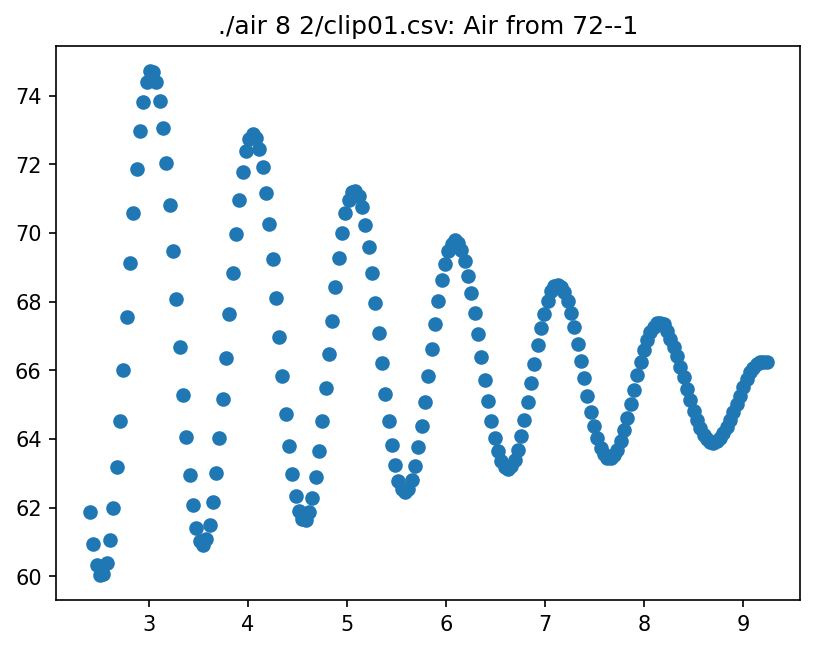


        Gas:          Air
        Water height:  0.082 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.01017+/-0.00020  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       -1.0243+/-0.0004 s
        Gamma:        1.5+/-0.8
        


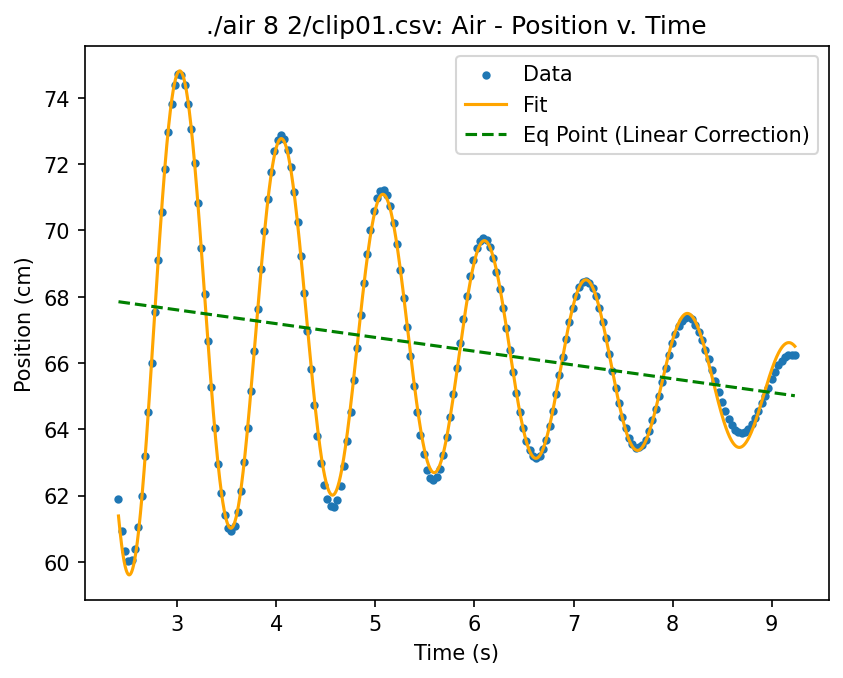

In [196]:
# calibration
c1 = (719, 50)
c2 = (836, 40)


# df = pd.read_csv("./air 8 2.csv")


r1 = DataRun(
    "./air 8 2/clip01.csv",  # CSV file
    1.2 * 60,  # start frame
    -1,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=8.2 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(1, 14, -2, 0, 50, 0),
)
r1.printStats()
Ts.append(abs(r1.getT()))

In [197]:
r1.firstFallDistance()

18
13.788888888888906


13.788888888888906

Pixels per Cm: -11.7


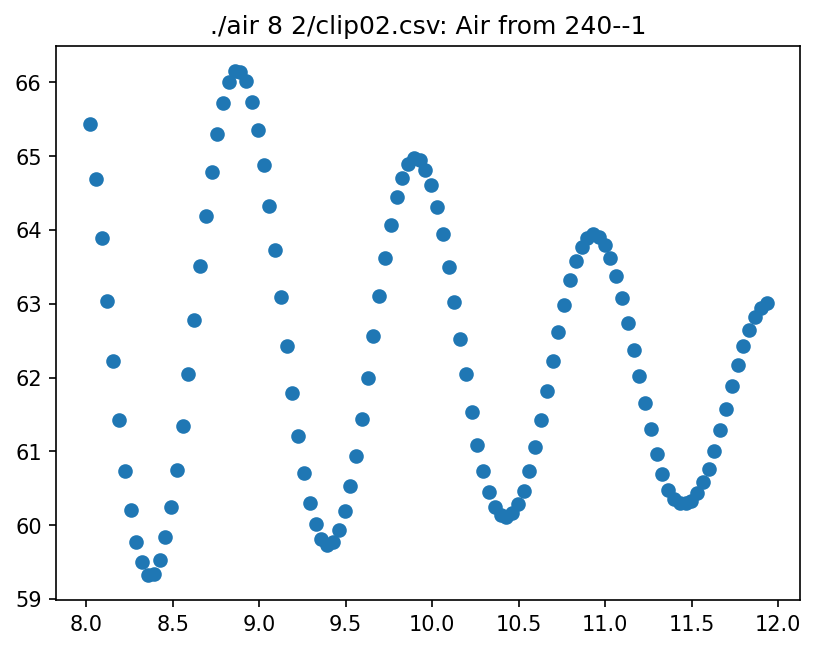


        Gas:          Air
        Water height:  0.082 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.01017+/-0.00020  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       1.02745+/-0.00026 s
        Gamma:        1.5+/-0.8
        


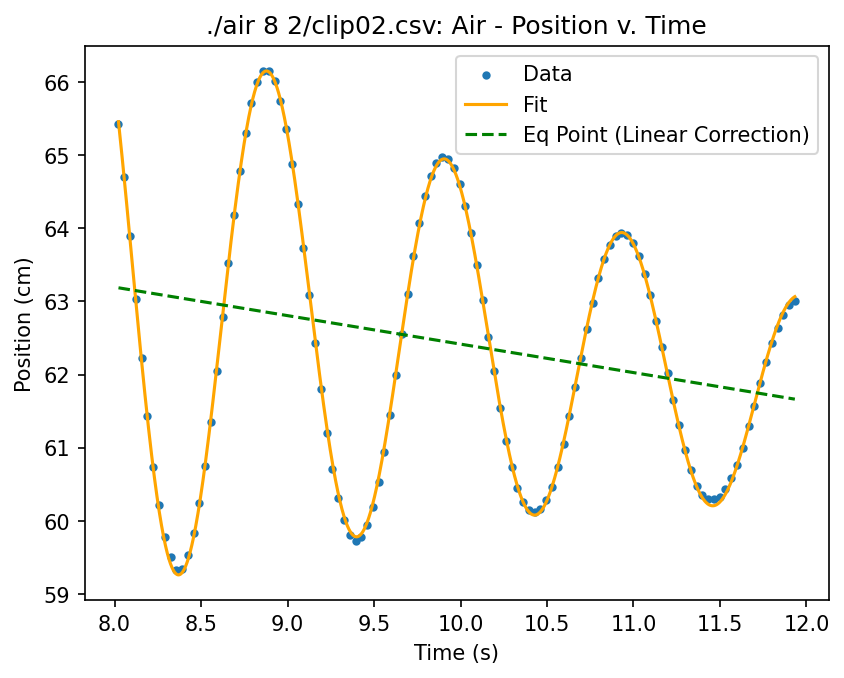

In [198]:
r2 = DataRun(
    "./air 8 2/clip02.csv",  # CSV file
    4 * 60,  # start frame
    -1,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=8.2 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(1, 14, -2, 0, 50, 0),
)
r2.printStats()
Ts.append(abs(r2.getT()))

In [199]:
r2.firstFallDistance()

25
6.421367521367522


6.421367521367522

Pixels per Cm: -11.7


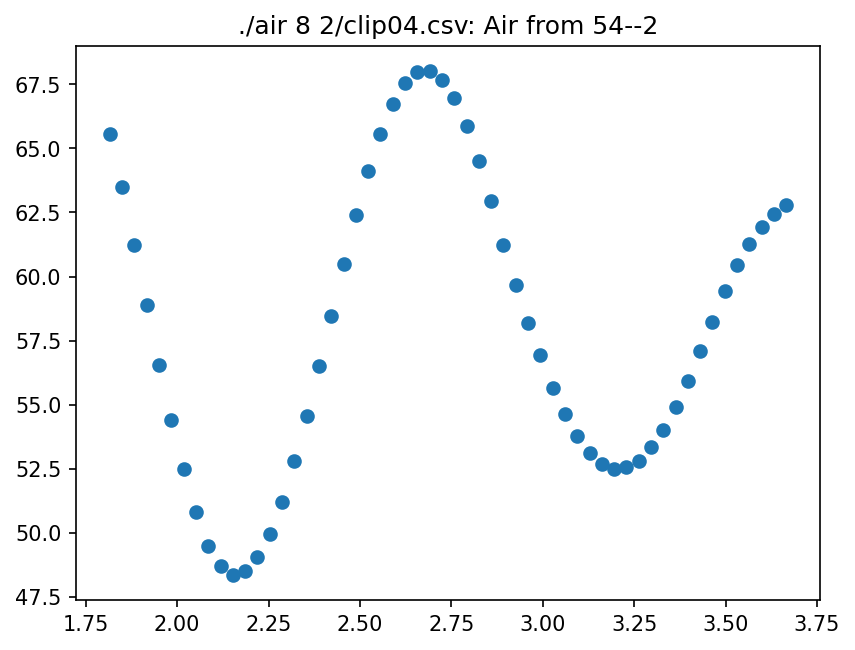


        Gas:          Air
        Water height:  0.082 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.01017+/-0.00020  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       1.042+/-0.004 s
        Gamma:        1.5+/-0.7
        


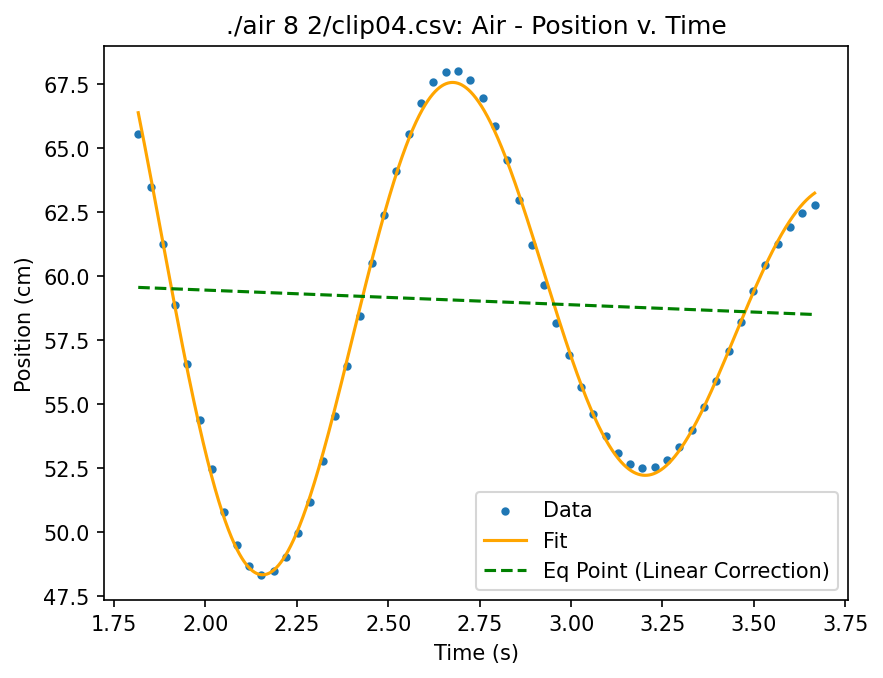

In [200]:
r3 = DataRun(
    "./air 8 2/clip04.csv",  # CSV file
    0.9 * 60,  # start frame
    -2,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=8.2 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=3,
    FPS=30,
    p0=(1, 14, -2, 0, 50, 0),
)
r3.printStats()
Ts.append(abs(r3.getT()))

In [201]:
Tn = [t.n for t in Ts]
print("period: ", np.mean(Tn), "+-", np.std(Tn))
periods.append(np.mean(Tn))
periods_err.append(np.std(Tn))

period:  1.0312629452294984 +- 0.007717344865106862


## Water height: 16.4 cm

In [202]:
Ts = []

Pixels per Cm: -22.0


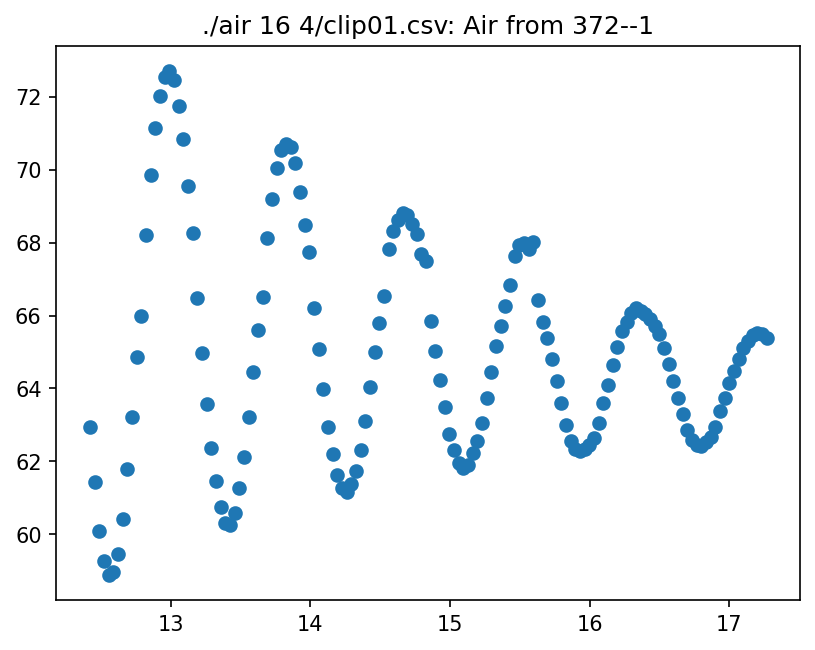


        Gas:          Air
        Water height:  0.164 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.00682+/-0.00014  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       0.8431+/-0.0005 s
        Gamma:        1.5+/-0.8
        


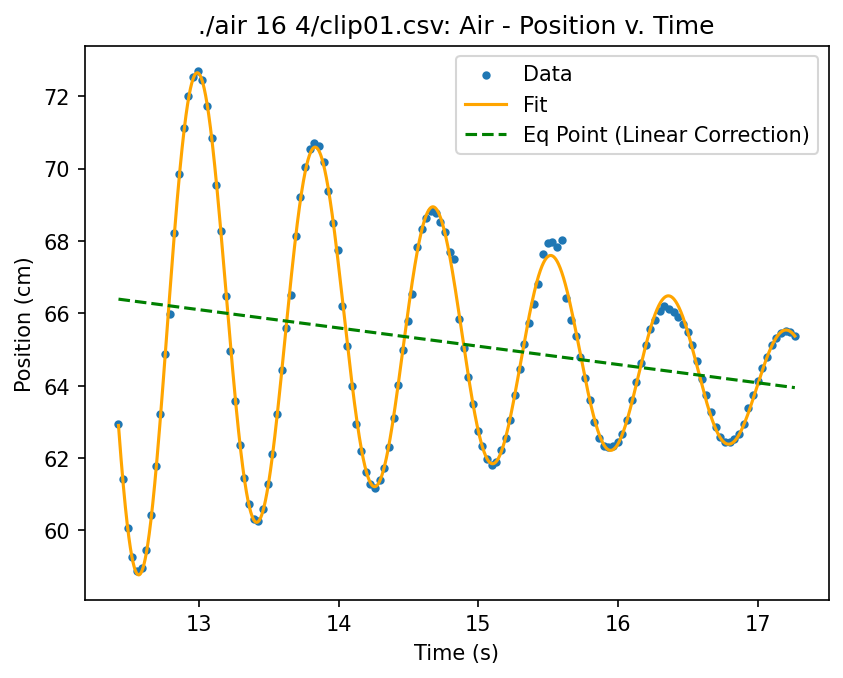

In [203]:
# calibration
c1 = (1315, 50)
c2 = (1535, 40)


r1 = DataRun(
    "./air 16 4/clip01.csv",  # CSV file
    6.2 * 60,  # start frame
    -1,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=16.4 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(0.5, 14, -2, 0, 50, 0),
)
r1.printStats()
Ts.append(abs(r1.getT()))

Pixels per Cm: -22.0


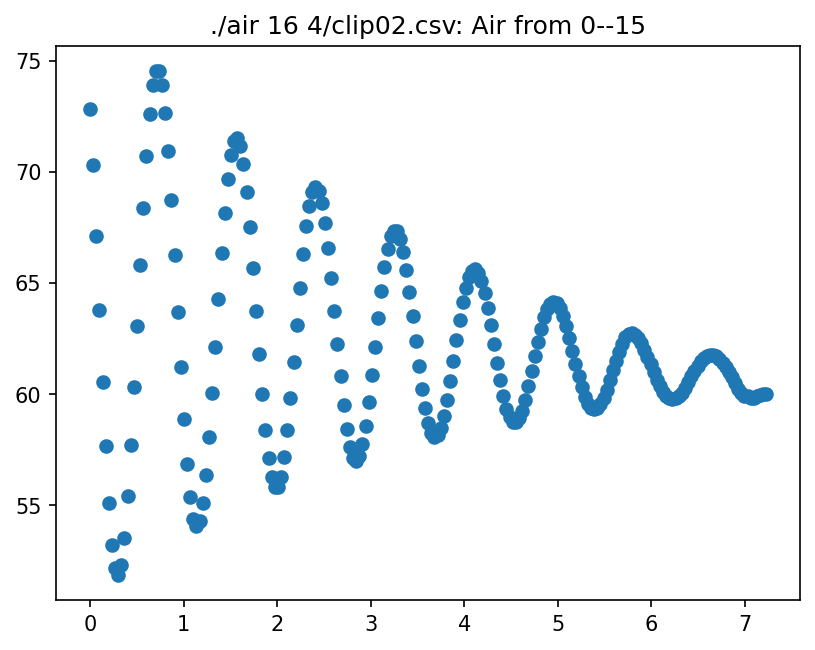


        Gas:          Air
        Water height:  0.164 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.00682+/-0.00014  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       0.84622+/-0.00031 s
        Gamma:        1.5+/-0.8
        


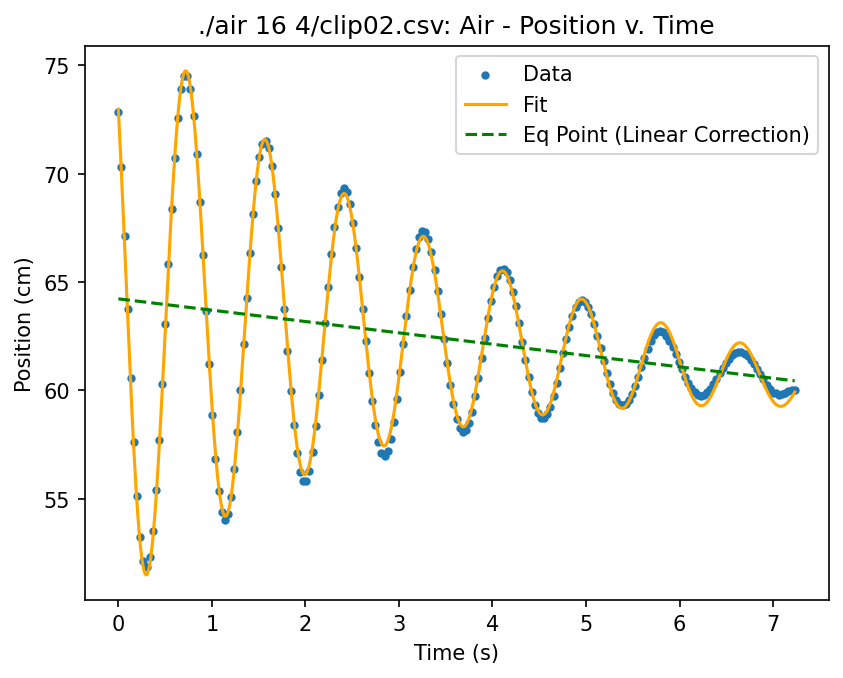

In [204]:
r2 = DataRun(
    "./air 16 4/clip02.csv",  # CSV file
    0 * 6.2 * 60,  # start frame
    -15,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=16.4 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(0.8, 14, -2, 0, 50, 0),
)
r2.printStats()
Ts.append(abs(r2.getT()))

Pixels per Cm: -22.0


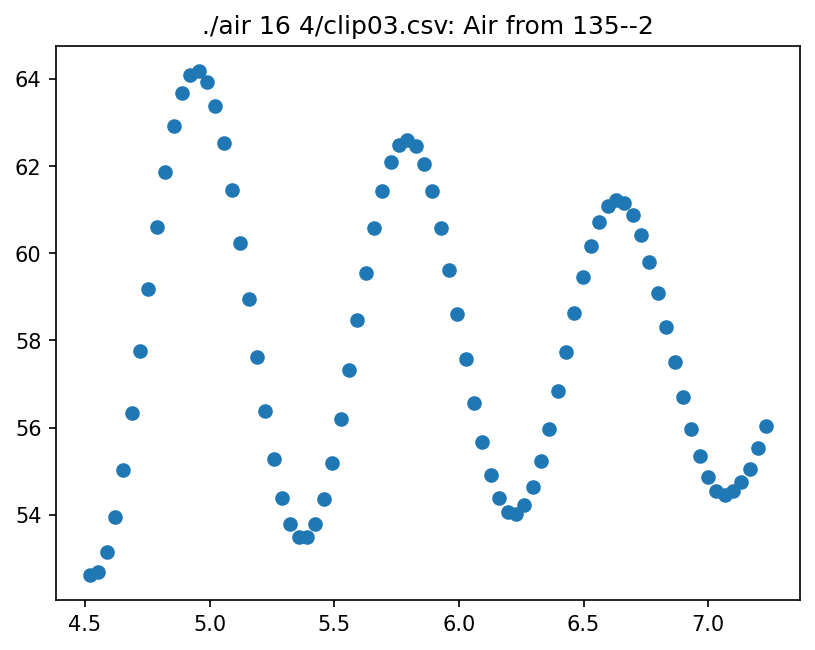

 intdy--  t (=r1) illegal        


/var/folders/c_/60wzl10549z76183158nyxfc0000gn/T/ipykernel_68766/1616808359.py:64: RuntimeWarning: overflow encountered in scalar multiply
  dp = -2 * zeta * w0 * p - w0**2 * x
/var/folders/c_/60wzl10549z76183158nyxfc0000gn/T/ipykernel_68766/1616808359.py:64: RuntimeWarning: invalid value encountered in scalar subtract
  dp = -2 * zeta * w0 * p - w0**2 * x
/opt/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


      in above message,  r1 =  0.5123394495413D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.5112821081957D+01   r2 =  0.5112821081958D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.5156880733945D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.5112821081957D+01   r2 =  0.5112821081958D+01
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.5156880733945D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.5123394495413D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.5112821081957D+01   r2 =  0.5112821081958D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.5156880733945D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.5112821081957D+01   r2 =  0.5112821081958D+01
 lsoda--  trouble

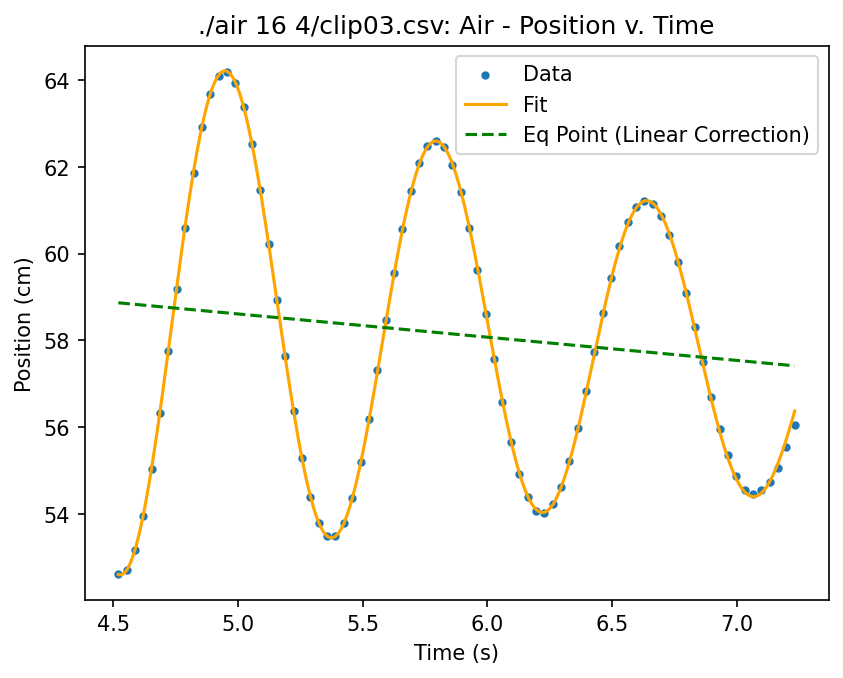

In [205]:
r3 = DataRun(
    "./air 16 4/clip03.csv",  # CSV file
    4.5 * 30,  # start frame
    -2,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=16.4 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(1, 14, -2, 0, 50, 0),
)
r3.printStats()
Ts.append(abs(r3.getT()))

Pixels per Cm: -22.0


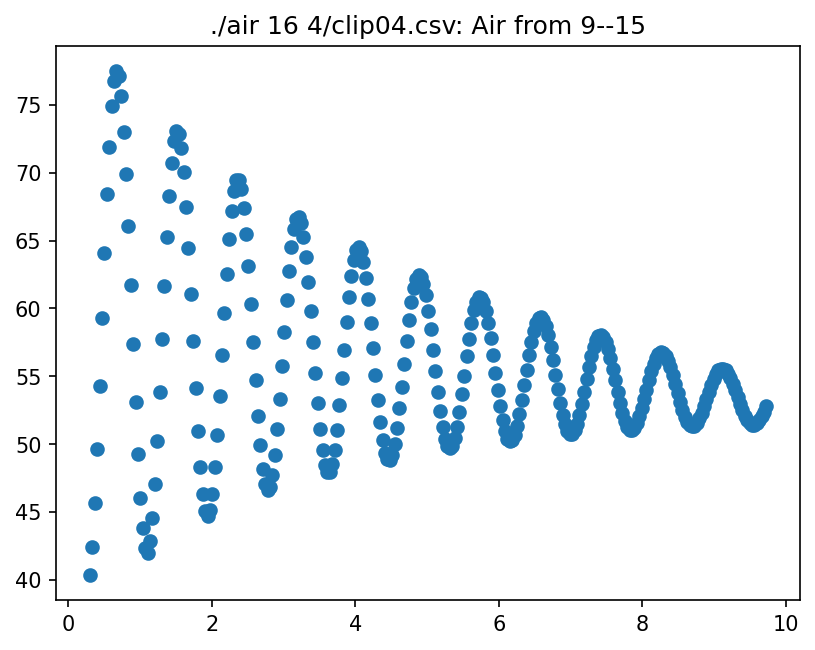

 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4681917211329D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.4667913210851D+01   r2 =  0.4667913210851D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4715359477124D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.4667913210851D+01   r2 =  0.4667913210851D+01
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.4715359477124D+01


/var/folders/c_/60wzl10549z76183158nyxfc0000gn/T/ipykernel_68766/1616808359.py:64: RuntimeWarning: overflow encountered in scalar multiply
  dp = -2 * zeta * w0 * p - w0**2 * x
/var/folders/c_/60wzl10549z76183158nyxfc0000gn/T/ipykernel_68766/1616808359.py:64: RuntimeWarning: invalid value encountered in scalar subtract
  dp = -2 * zeta * w0 * p - w0**2 * x
/opt/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4681917211329D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.4667913210851D+01   r2 =  0.4667913210851D+01
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4715359477124D+01
      t not in interval tcur - hu (= r1) to tcur (=r2)       
      in above,  r1 =  0.4667913210851D+01   r2 =  0.4667913210851D+01
 lsoda--  trouble from intdy. itask = i1, tout = r1  
      in above message,  i1 =         1
      in above message,  r1 =  0.4715359477124D+01

        Gas:          Air
        Water height:  0.164 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.00682+/-0.00014  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       0.8384+/-0.0004 s
        Gamma:        1.5+/-0.8
        
 intdy--  t (=r1) illegal        
      in above message,  r1 =  0.4681917211329D+01
      t 

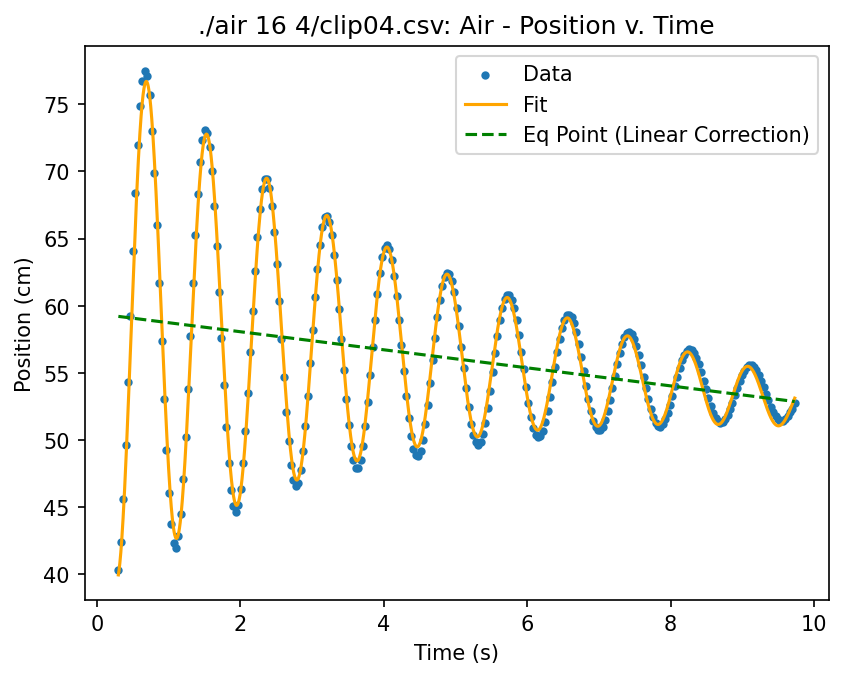

In [206]:
r4 = DataRun(
    "./air 16 4/clip04.csv",  # CSV file
    0.3 * 30,  # start frame
    -15,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=16.4 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(1, 14, -2, 0, 50, 0),
)
r4.printStats()
Ts.append(abs(r4.getT()))

In [207]:
Tn = [t.n for t in Ts]
print("period: ", np.mean(Tn), "+-", np.std(Tn))
periods.append(np.mean(Tn))
periods_err.append(np.std(Tn))

period:  0.8432686114584999 +- 0.003030657570925645


## Water height: 24.6

In [208]:
Ts = []

Pixels per Cm: -16.8


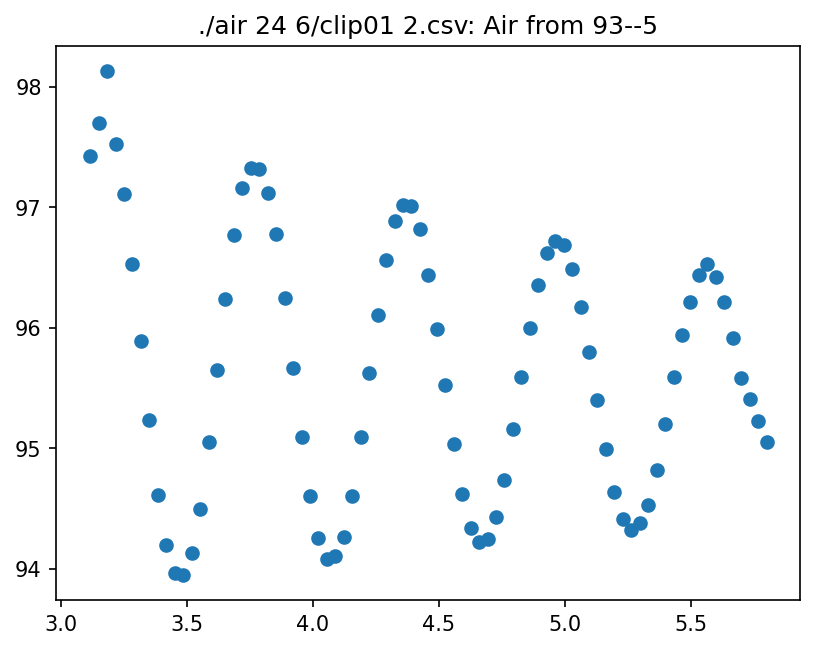


        Gas:          Air
        Water height:  0.246 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.00347+/-0.00008  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       0.5992+/-0.0006 s
        Gamma:        1.5+/-0.8
        


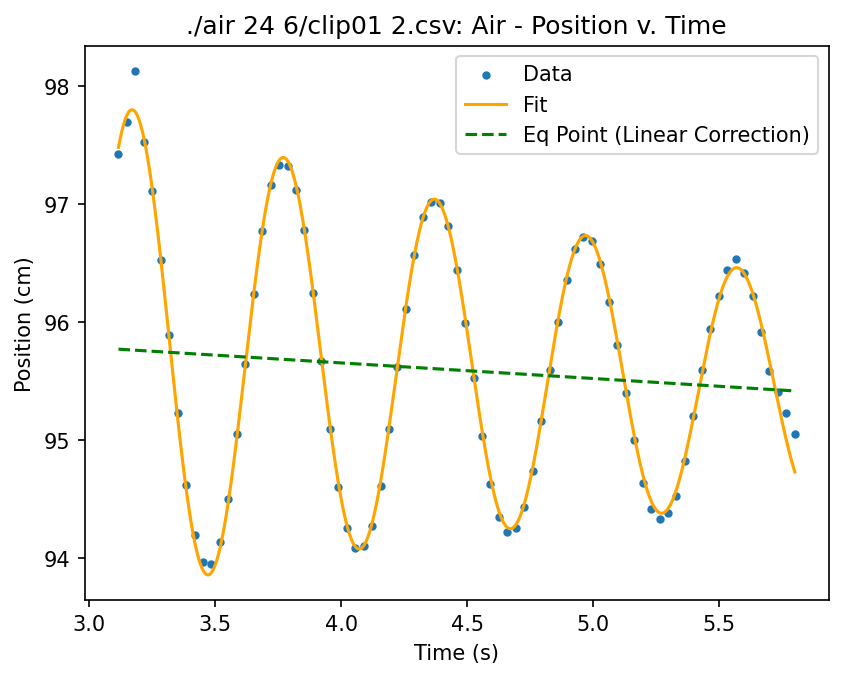

In [209]:
# calibration
c1 = (1040, 60)
c2 = (1208, 50)
r1 = DataRun(
    "./air 24 6/clip01 2.csv",  # CSV file
    3.1 * 30,  # start frame
    -5,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=24.6 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(1, 14, -3, 0, 50, 0),
)
r1.printStats()
Ts.append(abs(r1.getT()))

Pixels per Cm: -16.8


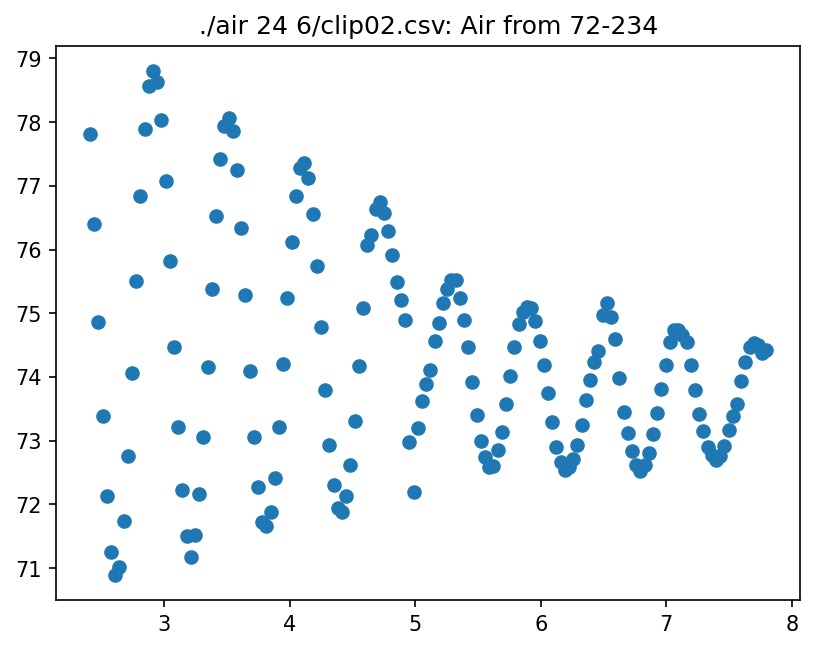


        Gas:          Air
        Water height:  0.246 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.00347+/-0.00008  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       0.5959+/-0.0008 s
        Gamma:        1.6+/-0.8
        


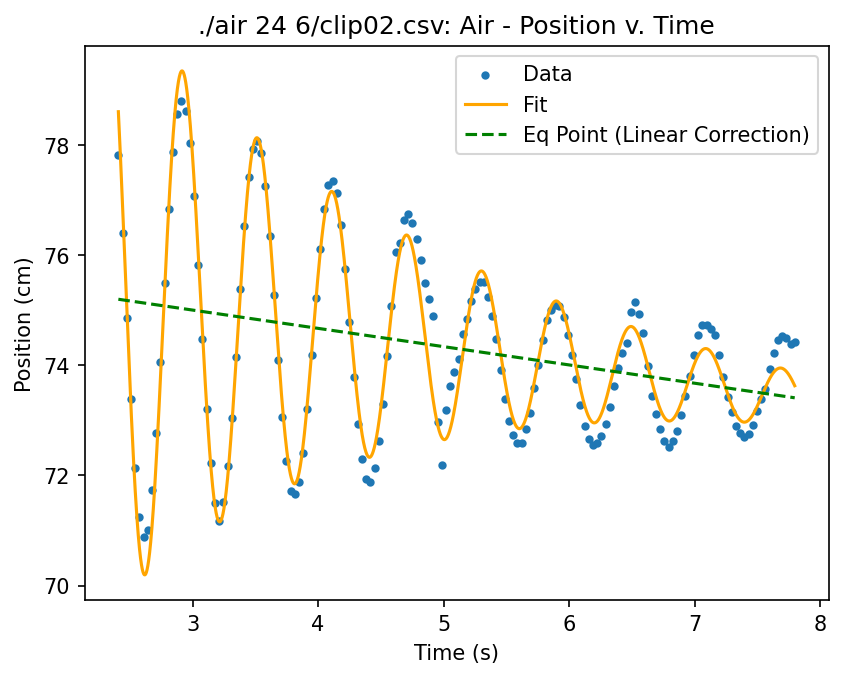

In [210]:
r2 = DataRun(
    "./air 24 6/clip02.csv",  # CSV file
    2.4 * 30,  # start frame
    7.8 * 30,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=24.6 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=0,
    FPS=30,
    p0=(1, 14, -3, 0, 50, 0),
)
r2.printStats()
Ts.append(abs(r2.getT()))

Pixels per Cm: -16.8


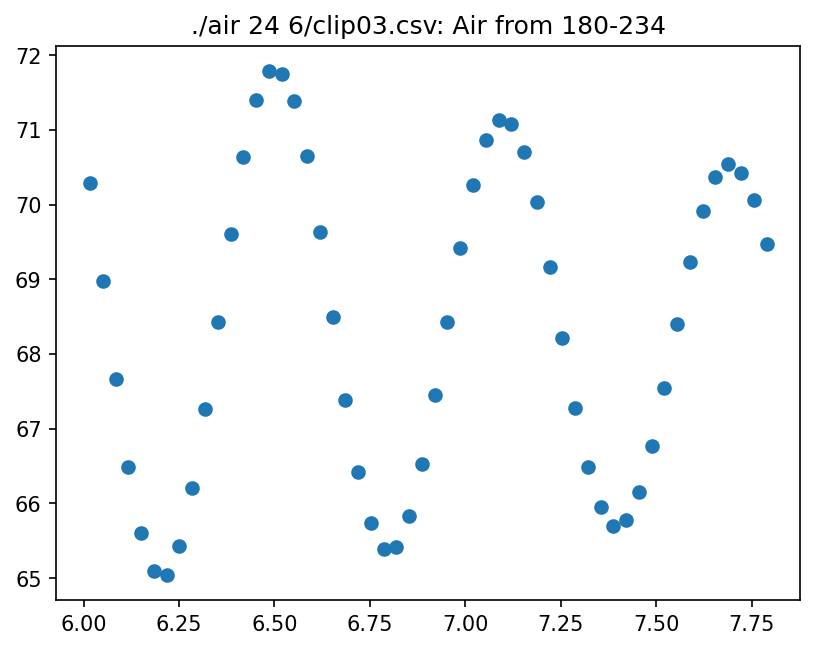


        Gas:          Air
        Water height:  0.246 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.00347+/-0.00008  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       0.59572+/-0.00016 s
        Gamma:        1.6+/-0.8
        


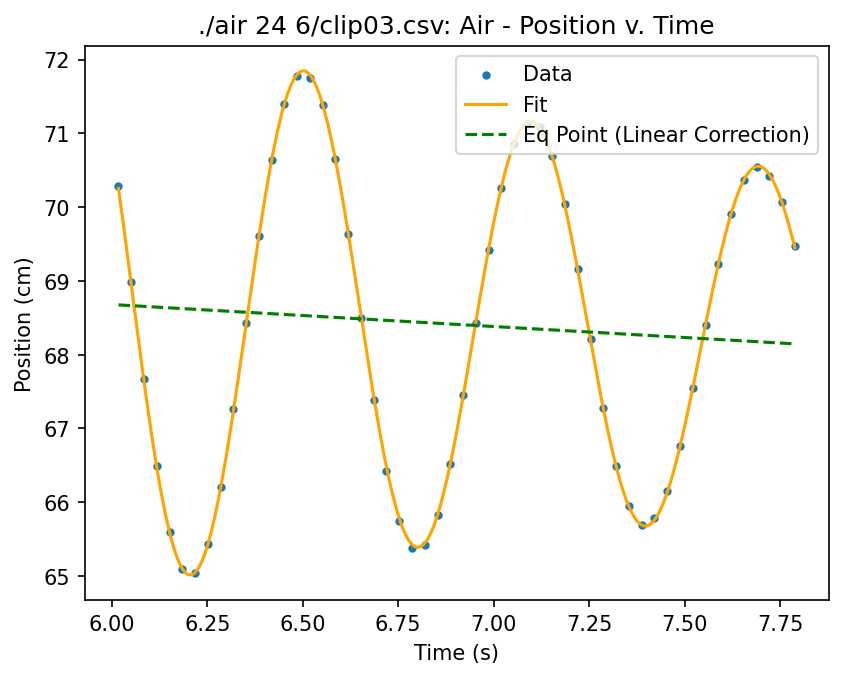

In [211]:
r3 = DataRun(
    "./air 24 6/clip03.csv",  # CSV file
    6 * 30,  # start frame
    7.8 * 30,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Air",  # string (gas)
    water_height=24.6 * 1e-2,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(1, 14, -3, 0, 50, 0),
)
r3.printStats()
Ts.append(abs(r3.getT()))

In [212]:
Tn = [t.n for t in Ts]
print("period: ", np.mean(Tn), "+-", np.std(Tn))
periods.append(np.mean(Tn))
periods_err.append(np.std(Tn))

period:  0.5969245894962011 +- 0.001582891960818321


# Argon

Pixels per Cm: -16.55


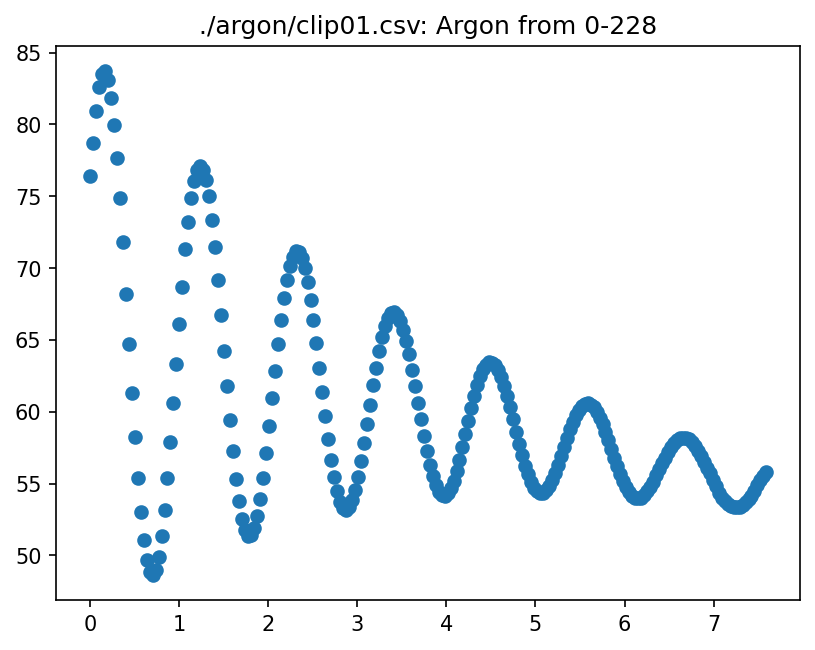


        Gas:          Argon
        Water height:  0 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.01351+/-0.00027  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       1.08480+/-0.00025 s
        Gamma:        1.8+/-0.9
        


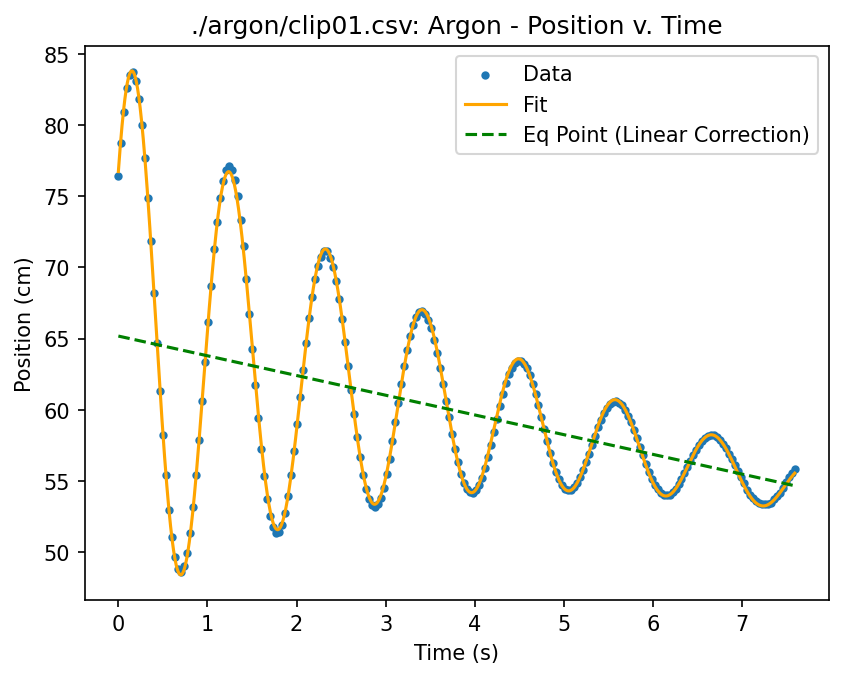

In [213]:
# calibration
c1 = (680, 60)
c2 = (1011, 40)


r1 = DataRun(
    "./argon/clip01.csv",  # CSV file
    0 * 30,  # start frame
    7.6 * 30,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Argon",  # string (gas)
    water_height=0,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(1, 14, -3, 0, 50, 0),
)
r1.printStats()

Pixels per Cm: -16.55


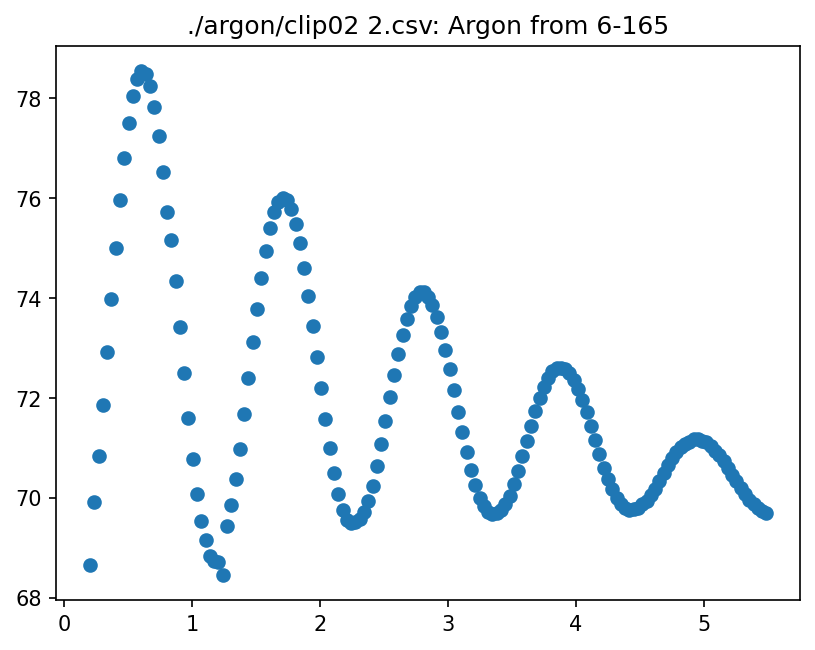


        Gas:          Argon
        Water height:  0 m
        Mass:         0.01651150+/-0.00000010  kg
        Volume:       0.01351+/-0.00027  m^3
        Pressure:     (1.0156+/-0.0017)e+05 pa
        Area:         0.00020+/-0.00005  m^2
        Period:       1.0909+/-0.0008 s
        Gamma:        1.8+/-0.9
        


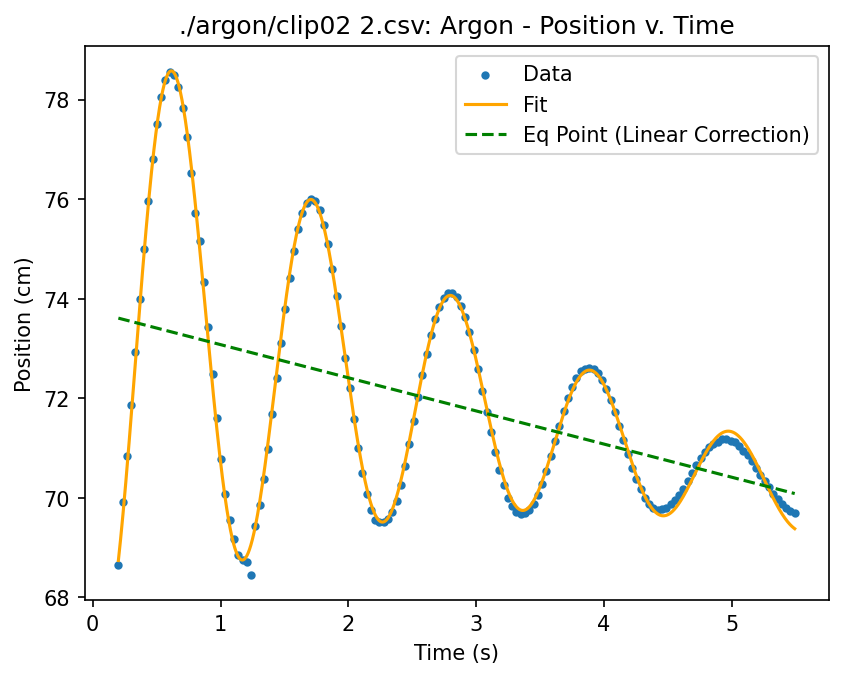

In [214]:
r2 = DataRun(
    "./argon/clip02 2.csv",  # CSV file
    0.2 * 30,  # start frame
    5.5 * 30,  # end frame
    c1,  # calibration 1 (pixel, height (cm))
    c2,  # calibration 2
    "Argon",  # string (gas)
    water_height=0,  # water height (m)
    pr=ufloat(101557.8, 169.319),  # pressure
    col=1,
    FPS=30,
    p0=(1, 14, -3, 0, 50, 0),
)
r2.printStats()

# Further Air Analysis

In [215]:
glassThickness = 0.65 * 1e-2  # ufloat(0.65, 0.1) * 1e-2
jardiameter = (
    24.1 * 1e-2 - 2 * glassThickness
)  # ufloat(24.1, 0.1) * 1e-2 - 2 * glassThickness
np.pi * (jardiameter / 2) ** 2

0.04082813812605295

In [216]:
print(periods)
print(periods_err)
Ts = [ufloat(nv, sv) for nv, sv in zip(periods, periods_err)]

[1.0312629452294984, 0.8432686114584999, 0.5969245894962011]
[0.007717344865106862, 0.003030657570925645, 0.001582891960818321]


[0.00308252 0.00643043 0.00977834]
[0.015917223589883695, 0.005111316803281317, 0.0018897342678566263]
Gamma: 1.5032946187311178 +- 0.0029230298873617866
V0: 0.01315582305064277 +- 1.4115871132157266e-05 m^3


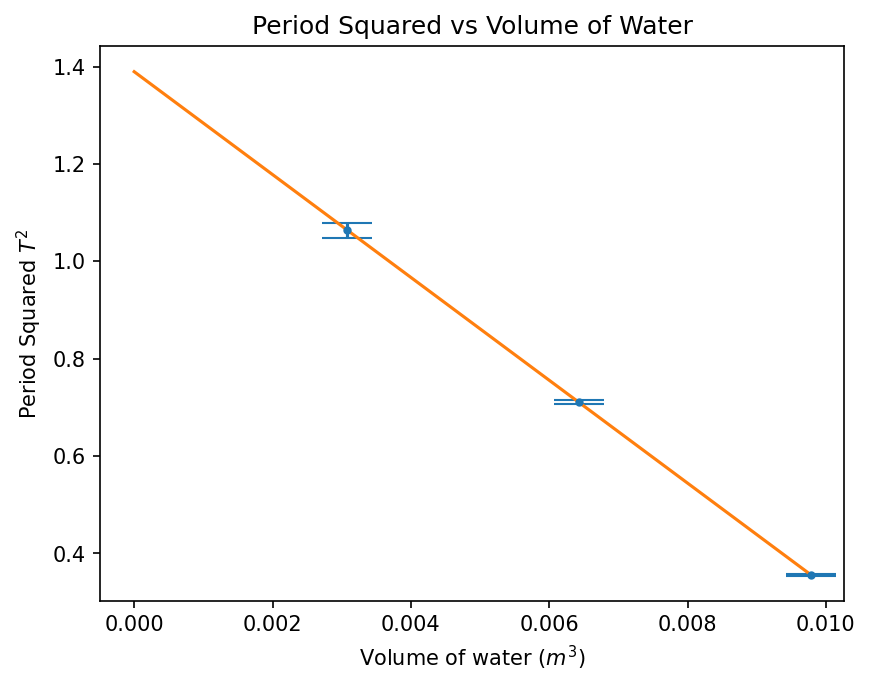

In [217]:
water_h = [8.2, 16.4, 24.6]
water_h = [w * 1e-2 for w in water_h]
water_h = np.asarray(water_h)
water_v = (water_h - glassThickness) * np.pi * (jardiameter / 2) ** 2

print(water_v)

# Ts = [ufloat(1.0243, 0.0004), ufloat(0.8431, 0.0005), ufloat(0.5959, 0.0008)]
Tsq = [t**2 for t in Ts]
Tsqn = [t.n for t in Tsq]
Terr = [t.s for t in Tsq]
plt.errorbar(water_v, Tsqn, Terr, capsize=12, fmt=".")
print(Terr)


def func(Vw, gamma, V0):
    C = (4 * np.pi**2 * r1.m.n) / (r1.pr.n * r1.A.n**2)
    return C * (V0 / gamma - Vw / gamma)


ps, cov = curve_fit(func, water_v, Tsqn)

t = np.linspace(0, max(water_v), 100)
plt.plot(t, func(t, *ps))
plt.xlabel("Volume of water ($m^3$)")
plt.ylabel("Period Squared $T^2$")
plt.title("Period Squared vs Volume of Water")


p_err = np.sqrt(np.diag(cov))
print(f"Gamma: {ps[0]} +- {p_err[0]}")
print(f"V0: {ps[1]} +- {p_err[1]} m^3")